# Model Experimentation

The aim of this stage is to develop a pipeline to create ML models for the task of recommending products to the users. The goal is to choose the best performing model on the defined metrics and save it for online consumption. I will be using the recommendations specific surprise package and scikit-learn for model development.

## Load the csv file and convert it into a user - product matrix

In [1]:
import pandas as pd
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('product_review_dataset.csv')

In [3]:
dataset_for_knn = dataset.drop(['Unnamed: 0'], axis=1)

In [4]:
# Removing all users who have not provided more than 1 rating
filtered_df = dataset_for_knn.groupby('userId').filter(lambda x : len(x) > 1)
n_users = filtered_df.nunique()[0]
n_items = filtered_df.nunique()[1]
print(filtered_df.nunique())

userId       71894
productId     5198
rating           4
dtype: int64


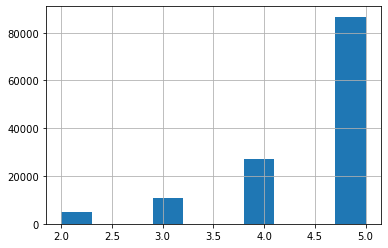

In [5]:
filtered_df = filtered_df.drop(filtered_df.query('rating == 5').sample(frac=0.4).index)
filtered_df['rating'].hist()

In [6]:
filtered_df.shape

(129909, 3)

In [9]:
# Convert the data to surprise dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(filtered_df, reader)

In [10]:
# Split the data into trainset and testset
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

In [11]:
# Building the matrix for collaborative filtering
matrix_for_cf = filtered_df.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)

In [12]:
matrix_for_cf = matrix_for_cf.astype('uint8')
matrix_for_cf

productId,0140503528,0245109919,030794655X,0310432065,0310520347,0310802636,0310806607,0310806615,0310818605,0310818621,...,B000A0WM2O,B000A1A900,B000A2AH0Q,B000A2AHUG,B000A2BJ1W,B000A2BJ44,B000A2BJ76,B000A2BJC6,B000A2BKAM,B000A2BKG6
userId,,,,,,,,,,,,,,,,,,,,,
A01003458IEUPS8LQ1QU,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0203183BAH3TR08FZGB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0220159ZRNBTRKLG08H,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03492194F0T997EZQ04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A040523674DKGFN0QEEQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZZLGDNQDCBSV,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZZRRYBQG57LF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZZSHWHHCLQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Baseline Models

In [13]:
# Popular Products
item_counts = filtered_df.groupby('productId').count().sort_values(ascending=False, by='rating')[:10]
item_counts.index

Index(['B00006IE7J', 'B00005249G', 'B00006IEEV', 'B00004Z5WK', 'B00002NDS3',
       'B00006JNJD', 'B00006IFAY', 'B00002NDRX', 'B00006IFI5', 'B00002NDRT'],
      dtype='object', name='productId')

## Memory Based Collaborative Filtering Method

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import numpy as np

In [15]:
def memory_based_top_ten(predicted, userId):
    return predicted[predicted.index == userId].T.sort_values(by = [userId], ascending=False).index[:10]

In [16]:
similarities = cosine_similarity(matrix_for_cf.T)

In [17]:
similarities.shape

(4909, 4909)

In [18]:
predicted_ratings =  (matrix_for_cf.dot(similarities) / np.array([np.abs(similarities).sum(axis=1)]))

In [19]:
predicted = predicted_ratings.to_numpy()[matrix_for_cf.to_numpy().nonzero()].flatten()
actual = matrix_for_cf.to_numpy()[matrix_for_cf.to_numpy().nonzero()].flatten()
rmse = (mean_squared_error(predicted, actual) ** 0.5)
rmse

3.0363683173243246

In [20]:
matrix_for_cf.columns[memory_based_top_ten(predicted_ratings, "AZZYGB3DSML0J")]

Index(['B00006RSO4', 'B0006HVURE', '1604189541', 'B00004Z61K', 'B0006HWSK2',
       'B00006RSTI', 'B00016ZL52', 'B000083E4W', 'B00006JNMN', 'B00006IEE3'],
      dtype='object', name='productId')

Memory based collaborative filtering involves no training or optimization and the results get worse as the data gets sparser. It is better to use scalable model based method for recommendation.  

## Model Based Collaborative Filtering Method 

### Clustering Based - KNN

This method takes a single product as input and produces output of 10 products which are similar to it.

In [21]:
from sklearn.neighbors import NearestNeighbors

In [22]:
def ten_similar_products(model, ratings_matrix, productId):
    index = np.where(ratings_matrix.columns == productId)
    distances, indices = model.kneighbors([ratings_matrix.iloc[:, index[0][0]].to_numpy()], n_neighbors=11)
    return ratings_matrix.iloc[:, indices[0]].columns

In [23]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(matrix_for_cf.T)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [24]:
matrix_for_cf.shape

(65960, 4909)

In [25]:
ten_similar_products(model_knn, matrix_for_cf, '0140503528')

Index(['0140503528', 'B00006IC8M', 'B0006HVEAW', '1439716048', 'B0003WN0DO',
       'B00006IF6E', 'B00006IF79', 'B0000AQOFM', 'B0000AQOFN', 'B0000AQOFL',
       'B0000AQOGQ'],
      dtype='object', name='productId')

### Matrix Factorization Based

In [26]:
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise.model_selection import cross_validate

In [27]:
def top_ten(predicted_df, userId):
    return predicted_df[predicted_df["uid"] == userId].sort_values(by = ['est'], ascending=False)[:10][['iid', 'r_ui', 'est']]

In [28]:
trainset_small, testset_large = train_test_split(data, test_size=0.8, random_state=10)

In [29]:
# SVD - Singular Value Decomposition
algo = SVD(10)

In [30]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7663  0.7680  0.7712  0.7636  0.7691  0.7676  0.0026  
MAE (testset)     0.5946  0.5928  0.5968  0.5929  0.5975  0.5949  0.0019  
Fit time          4.05    4.56    4.52    4.36    4.30    4.36    0.18    
Test time         0.74    0.40    0.41    0.39    0.37    0.46    0.14    


{'test_rmse': array([0.76629851, 0.76800638, 0.77124946, 0.76358806, 0.76909275]),
 'test_mae': array([0.59459699, 0.59278437, 0.59677634, 0.59289644, 0.59751238]),
 'fit_time': (4.05234694480896,
  4.558382511138916,
  4.522502660751343,
  4.3647918701171875,
  4.300334930419922),
 'test_time': (0.7448892593383789,
  0.40000009536743164,
  0.40545654296875,
  0.389362096786499,
  0.3692207336425781)}

In [31]:
predictions = algo.fit(trainset).test(testset_large)

In [32]:
top_ten(pd.DataFrame(predictions), "A3N77PJ4KP3CJP")

,iid,r_ui,est
53031,B00006IE2I,5.0,5.0
62296,B00006IE2L,5.0,5.0
7139,B00002NDRX,5.0,5.0
51005,B0006HWOCE,5.0,5.0
47885,B00078A00A,5.0,5.0
47481,B00007LOYS,5.0,5.0
65098,B0006ZERXA,5.0,5.0
43131,B00006JNMT,5.0,5.0
65456,B0002ABB6K,5.0,5.0
30314,B00005A9W3,5.0,5.0


In [33]:
top_ten(pd.DataFrame(predictions), "A3OXHLG6DIBRW8")

,iid,r_ui,est
41455,B00006IFEU,5.0,4.794822
60584,B00006IF67,5.0,4.752332
70629,B0000DH8HQ,5.0,4.750158
64001,B0002VS6HG,5.0,4.741764
73295,B0000AQNPB,5.0,4.696796
87030,B00009RAX5,5.0,4.694565
20931,B00009RAX5,5.0,4.694565
58159,B00006JNMR,5.0,4.682970
46960,B00006IEB3,5.0,4.678910
71304,B00005NIUB,5.0,4.665537


In [34]:
# Next Algorithm SVD++
algo2 = SVDpp()

In [35]:
cross_validate(algo2, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7617  0.7630  0.7575  0.7551  0.7612  0.7597  0.0029  
MAE (testset)     0.5924  0.5904  0.5900  0.5901  0.5940  0.5914  0.0016  
Fit time          22.88   24.16   24.39   22.99   22.97   23.48   0.65    
Test time         0.73    0.76    0.75    1.22    1.24    0.94    0.24    


{'test_rmse': array([0.76167347, 0.76300148, 0.75749632, 0.75509596, 0.76122952]),
 'test_mae': array([0.59243052, 0.59043266, 0.59000213, 0.59011245, 0.59398659]),
 'fit_time': (22.884407997131348,
  24.163511991500854,
  24.38516855239868,
  22.99188780784607,
  22.970086336135864),
 'test_time': (0.726149320602417,
  0.7631094455718994,
  0.7461621761322021,
  1.2223353385925293,
  1.2438502311706543)}

In [36]:
predictions = algo2.fit(trainset).test(testset_large)

In [37]:
top_ten(pd.DataFrame(predictions), "A3N77PJ4KP3CJP")

,iid,r_ui,est
2902,B00006IEAE,5.0,5.0
43131,B00006JNMT,5.0,5.0
93524,B000083E4Z,5.0,5.0
85485,B00006IFJ8,5.0,5.0
84296,B00006ICSJ,5.0,5.0
78082,B0006ZH66A,5.0,5.0
77400,B00004Z6JX,5.0,5.0
68751,B00006IFMQ,5.0,5.0
65525,B00006IC8I,5.0,5.0
65456,B0002ABB6K,5.0,5.0


In [38]:
top_ten(pd.DataFrame(predictions), "A3OXHLG6DIBRW8")

,iid,r_ui,est
74887,B00005A9W8,5.0,4.844269
41455,B00006IFEU,5.0,4.835689
73295,B0000AQNPB,5.0,4.810837
58159,B00006JNMR,5.0,4.778714
87030,B00009RAX5,5.0,4.763510
20931,B00009RAX5,5.0,4.763510
71304,B00005NIUB,5.0,4.755338
49714,B000050FZP,5.0,4.746526
927,B000050FZP,5.0,4.746526
70629,B0000DH8HQ,5.0,4.703798


In [39]:
# Next Algorithm Non-Negative Matrix Factorization
algo3 = NMF()

In [40]:
cross_validate(algo3, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9951  1.0091  0.9891  0.9928  0.9892  0.9951  0.0074  
MAE (testset)     0.7997  0.8088  0.7859  0.7920  0.7851  0.7943  0.0089  
Fit time          22.23   22.23   22.63   23.97   22.61   22.73   0.64    
Test time         0.35    0.34    0.36    0.35    0.84    0.45    0.20    


{'test_rmse': array([0.99509066, 1.00908897, 0.9890622 , 0.99279265, 0.98921643]),
 'test_mae': array([0.79968308, 0.80879432, 0.78591819, 0.7920326 , 0.78507399]),
 'fit_time': (22.23043918609619,
  22.22859811782837,
  22.63227915763855,
  23.967058181762695,
  22.612872838974),
 'test_time': (0.3499114513397217,
  0.34145641326904297,
  0.3591325283050537,
  0.3532998561859131,
  0.8418269157409668)}

In [41]:
predictions = algo3.fit(trainset).test(testset_large)

In [42]:
top_ten(pd.DataFrame(predictions), "A3N77PJ4KP3CJP")

,iid,r_ui,est
42804,B0006HVGSC,5.0,5.000000
65098,B0006ZERXA,5.0,5.000000
7139,B00002NDRX,5.0,5.000000
84296,B00006ICSJ,5.0,4.996274
14563,B00006IF4R,5.0,4.981241
25342,B0000DHKRG,5.0,4.970682
2902,B00006IEAE,5.0,4.945385
19309,B0006HVMUY,5.0,4.942837
22197,B0000225AQ,5.0,4.917865
19785,B00006IDSP,5.0,4.865255


In [43]:
top_ten(pd.DataFrame(predictions), "A3OXHLG6DIBRW8")

,iid,r_ui,est
74887,B00005A9W8,5.0,5.000000
70629,B0000DH8HQ,5.0,4.894439
73295,B0000AQNPB,5.0,4.796756
45550,B0006SVBO0,5.0,4.739622
15094,B0006SVBO0,5.0,4.739622
85946,B0006SVBO0,5.0,4.739622
74850,B0006SVBO0,5.0,4.739622
60584,B00006IF67,5.0,4.734383
87030,B00009RAX5,5.0,4.725012
20931,B00009RAX5,5.0,4.725012


### Deep Learning

In [44]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import ml_metrics
from sklearn.metrics import accuracy_score

In [45]:
def top_ten_predicted(model, user, items):
    predictions = model.predict([np.array([user]*len(items)), items])
    predictions_df = pd.DataFrame(predictions, columns=['ratings'])
    item_id_df = pd.DataFrame(item_encoding, columns = ['itemId'])
    item_id_df['ratings'] = predictions_df['ratings']
    top_10 = item_id_df.sort_values(by = ['ratings'], ascending=False)[:10]
    return top_10['itemId'].values

In [46]:
def top_ten_actual(df, user):
    return df[df['userId'] == user].sort_values(by = ['rating'], ascending=False)[:100]['productId'].values

In [47]:
user_enc = LabelEncoder()
filtered_df['userId'] = user_enc.fit_transform(filtered_df['userId'].values)

In [48]:
item_enc = LabelEncoder()
filtered_df['productId'] = item_enc.fit_transform(filtered_df['productId'].values)

In [49]:
item_encoding = filtered_df['productId'].unique()

In [50]:
user_encoding = filtered_df['userId'].unique()

In [51]:
item_encoding

array([   0,    1,    2, ..., 4908, 4904, 4905])

In [52]:
user_encoding

array([28778, 65344, 21402, ..., 38024, 59789, 53297])

In [53]:
X = np.array([filtered_df['userId'], filtered_df['productId']]).T
y = np.array(filtered_df['rating']).T

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116918, 2), (12991, 2), (116918,), (12991,))

In [55]:
def Recommender_1(n_users, n_items, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    item = Input(shape=(1,))
    i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
    i = Reshape((n_factors,))(i)
    
    x = Dot(axes=1)([u, i])
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [56]:
model = Recommender_1(n_users, n_items, 50)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        3594700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        259900      input_2[0][0]                    
______________________________________________________________________________________________

In [57]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [58]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 67s 36ms/step - loss: 19.8201 - val_loss: 11.9895
Epoch 2/20
1827/1827 [==============================] - 80s 44ms/step - loss: 4.7349 - val_loss: 10.9532
Epoch 3/20
1827/1827 [==============================] - 80s 44ms/step - loss: 3.8343 - val_loss: 10.7198
Epoch 4/20
1827/1827 [==============================] - 79s 43ms/step - loss: 3.9573 - val_loss: 10.5922
Epoch 5/20
1827/1827 [==============================] - 79s 43ms/step - loss: 4.0993 - val_loss: 10.3661
Epoch 6/20
1827/1827 [==============================] - 77s 42ms/step - loss: 3.9908 - val_loss: 10.1300
Epoch 7/20
1827/1827 [==============================] - 75s 41ms/step - loss: 3.7490 - val_loss: 9.8974
Epoch 8/20
1827/1827 [==============================] - 75s 41ms/step - loss: 3.5850 - val_loss: 9.7333
Epoch 9/20
1827/1827 [==============================] - 75s 41ms/step - loss: 3.4795 - val_loss: 9.6119
Epoch 10/20
1827/1827 [==============================] - 

In [59]:
prediction = model.predict(X_test_array)

In [60]:
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.15010391809714418

In [61]:
top_ten_predicted(model, 3, item_encoding)

array([2320, 1839, 2663, 1576, 1940, 1859, 2804, 2098, 1670, 2660])

In [62]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def Recommender_2(n_users, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    item = Input(shape=(1,))
    i = EmbeddingLayer(n_items, n_factors)(item)
    ib = EmbeddingLayer(n_items, 1)(item)
    x = Dot(axes=1)([u, i])
    x = Add()([x, ub, ib])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [63]:
model = Recommender_2(n_users, n_items, 50, 1, 5)
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 85s 46ms/step - loss: 1.6588 - val_loss: 0.8842
Epoch 2/20
1827/1827 [==============================] - 82s 45ms/step - loss: 0.5268 - val_loss: 0.8611
Epoch 3/20
1827/1827 [==============================] - 67s 37ms/step - loss: 0.5069 - val_loss: 0.7973
Epoch 4/20
1827/1827 [==============================] - 65s 36ms/step - loss: 0.4804 - val_loss: 0.7899
Epoch 5/20
1827/1827 [==============================] - 63s 35ms/step - loss: 0.4822 - val_loss: 0.7913
Epoch 6/20
1827/1827 [==============================] - 63s 35ms/step - loss: 0.4767 - val_loss: 0.7790
Epoch 7/20
1827/1827 [==============================] - 63s 34ms/step - loss: 0.4589 - val_loss: 0.7638
Epoch 8/20
1827/1827 [==============================] - 63s 34ms/step - loss: 0.4440 - val_loss: 0.7579
Epoch 9/20
1827/1827 [==============================] - 63s 34ms/step - loss: 0.4391 - val_loss: 0.7533
Epoch 10/20
1827/1827 [==============================] - 62s 34m

In [64]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.6546840120083135

In [65]:
top_ten_predicted(model, 3, item_encoding)

array([2660, 2330, 1815, 2627, 2495, 1473, 3169, 2524, 2197, 1578])

In [66]:
# 100 factors
model = RecommenderV2(n_users, n_items, 100, 1, 5)
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 124s 67ms/step - loss: 1.6983 - val_loss: 1.1130
Epoch 2/20
1827/1827 [==============================] - 66s 36ms/step - loss: 0.8633 - val_loss: 1.0397
Epoch 3/20
1827/1827 [==============================] - 66s 36ms/step - loss: 0.8484 - val_loss: 0.9557
Epoch 4/20
1827/1827 [==============================] - 65s 35ms/step - loss: 0.7970 - val_loss: 0.9250
Epoch 5/20
1827/1827 [==============================] - 65s 36ms/step - loss: 0.7991 - val_loss: 0.9383
Epoch 6/20
1827/1827 [==============================] - 64s 35ms/step - loss: 0.8029 - val_loss: 0.9188
Epoch 7/20
1827/1827 [==============================] - 65s 36ms/step - loss: 0.7897 - val_loss: 0.9067
Epoch 8/20
1827/1827 [==============================] - 64s 35ms/step - loss: 0.7730 - val_loss: 0.9054
Epoch 9/20
1827/1827 [==============================] - 65s 35ms/step - loss: 0.7514 - val_loss: 0.8972
Epoch 10/20
1827/1827 [==============================] - 65s 35

In [67]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.658147948579786

In [68]:
top_ten_predicted(model, 3, item_encoding)

array([2660, 2522, 1427, 4226, 2085, 1070, 2303, 2649, 3705, 2593])

In [69]:
# 200 factors
model = RecommenderV2(n_users, n_items, 200, 1, 5)
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 158s 86ms/step - loss: 1.7828 - val_loss: 1.6186
Epoch 2/20
1827/1827 [==============================] - 159s 87ms/step - loss: 1.4263 - val_loss: 1.4421
Epoch 3/20
1827/1827 [==============================] - 158s 87ms/step - loss: 1.3845 - val_loss: 1.2612
Epoch 4/20
1827/1827 [==============================] - 160s 88ms/step - loss: 1.2577 - val_loss: 1.2290
Epoch 5/20
1827/1827 [==============================] - 160s 88ms/step - loss: 1.2409 - val_loss: 1.2043
Epoch 6/20
1827/1827 [==============================] - 159s 87ms/step - loss: 1.2551 - val_loss: 1.1895
Epoch 7/20
1827/1827 [==============================] - 160s 88ms/step - loss: 1.2315 - val_loss: 1.1792
Epoch 8/20
1827/1827 [==============================] - 160s 88ms/step - loss: 1.2304 - val_loss: 1.1596
Epoch 9/20
1827/1827 [==============================] - 161s 88ms/step - loss: 1.1924 - val_loss: 1.1602
Epoch 10/20
1827/1827 [==============================] 

In [70]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.6576860903702564

In [71]:
top_ten_predicted(model, 3, item_encoding)

array([2120, 2616, 4025, 2660, 4661, 2664, 1383, 3230, 3372, 2004])

In [72]:
# 25 factors
model = RecommenderV2(n_users, n_items, 25, 1, 5)
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 16s 8ms/step - loss: 1.6371 - val_loss: 0.7744
Epoch 2/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.3910 - val_loss: 0.7809
Epoch 3/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.3338 - val_loss: 0.7389
Epoch 4/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.3163 - val_loss: 0.7237
Epoch 5/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.3166 - val_loss: 0.7181
Epoch 6/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.3117 - val_loss: 0.7067
Epoch 7/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.3003 - val_loss: 0.7058
Epoch 8/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.2955 - val_loss: 0.6960
Epoch 9/20
1827/1827 [==============================] - 15s 8ms/step - loss: 0.2872 - val_loss: 0.6931
Epoch 10/20
1827/1827 [==============================] - 15s 8ms/step - l

In [73]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.6449080132399353

In [74]:
top_ten_predicted(model, 3, item_encoding)

array([2660, 2627, 3113, 2533, 4696, 2033, 3316, 2034, 1746, 2655])